Работа с временными рядами.

Известно ежемесячное число смертей в результате несчастного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)
import pmdarima

In [2]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [3]:
dataset = pd.read_csv('accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])
plotly_df(dataset, title = "Deaths monthly")

По графику заметна сезонность. Наибольшее количество сметрей в течении года выпадает на июль, наименьшее - февраль. Также, вторые "пики" - октябрь/декабрь.

In [4]:
dataset

,Deaths
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017
...,...
1978-08-01,9827
1978-09-01,9110
1978-10-01,9070


In [5]:
dataset.describe()

,Deaths
count,72.000000
mean,8787.736111
std,958.338013
min,6892.000000
25%,8089.000000
50%,8728.500000
75%,9323.250000
max,11317.000000


In [6]:
def plotMovingAverage(series, n):
    
    rolling_mean = series.rolling(window=n).mean()
    
    plt.figure(figsize=(30,10))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

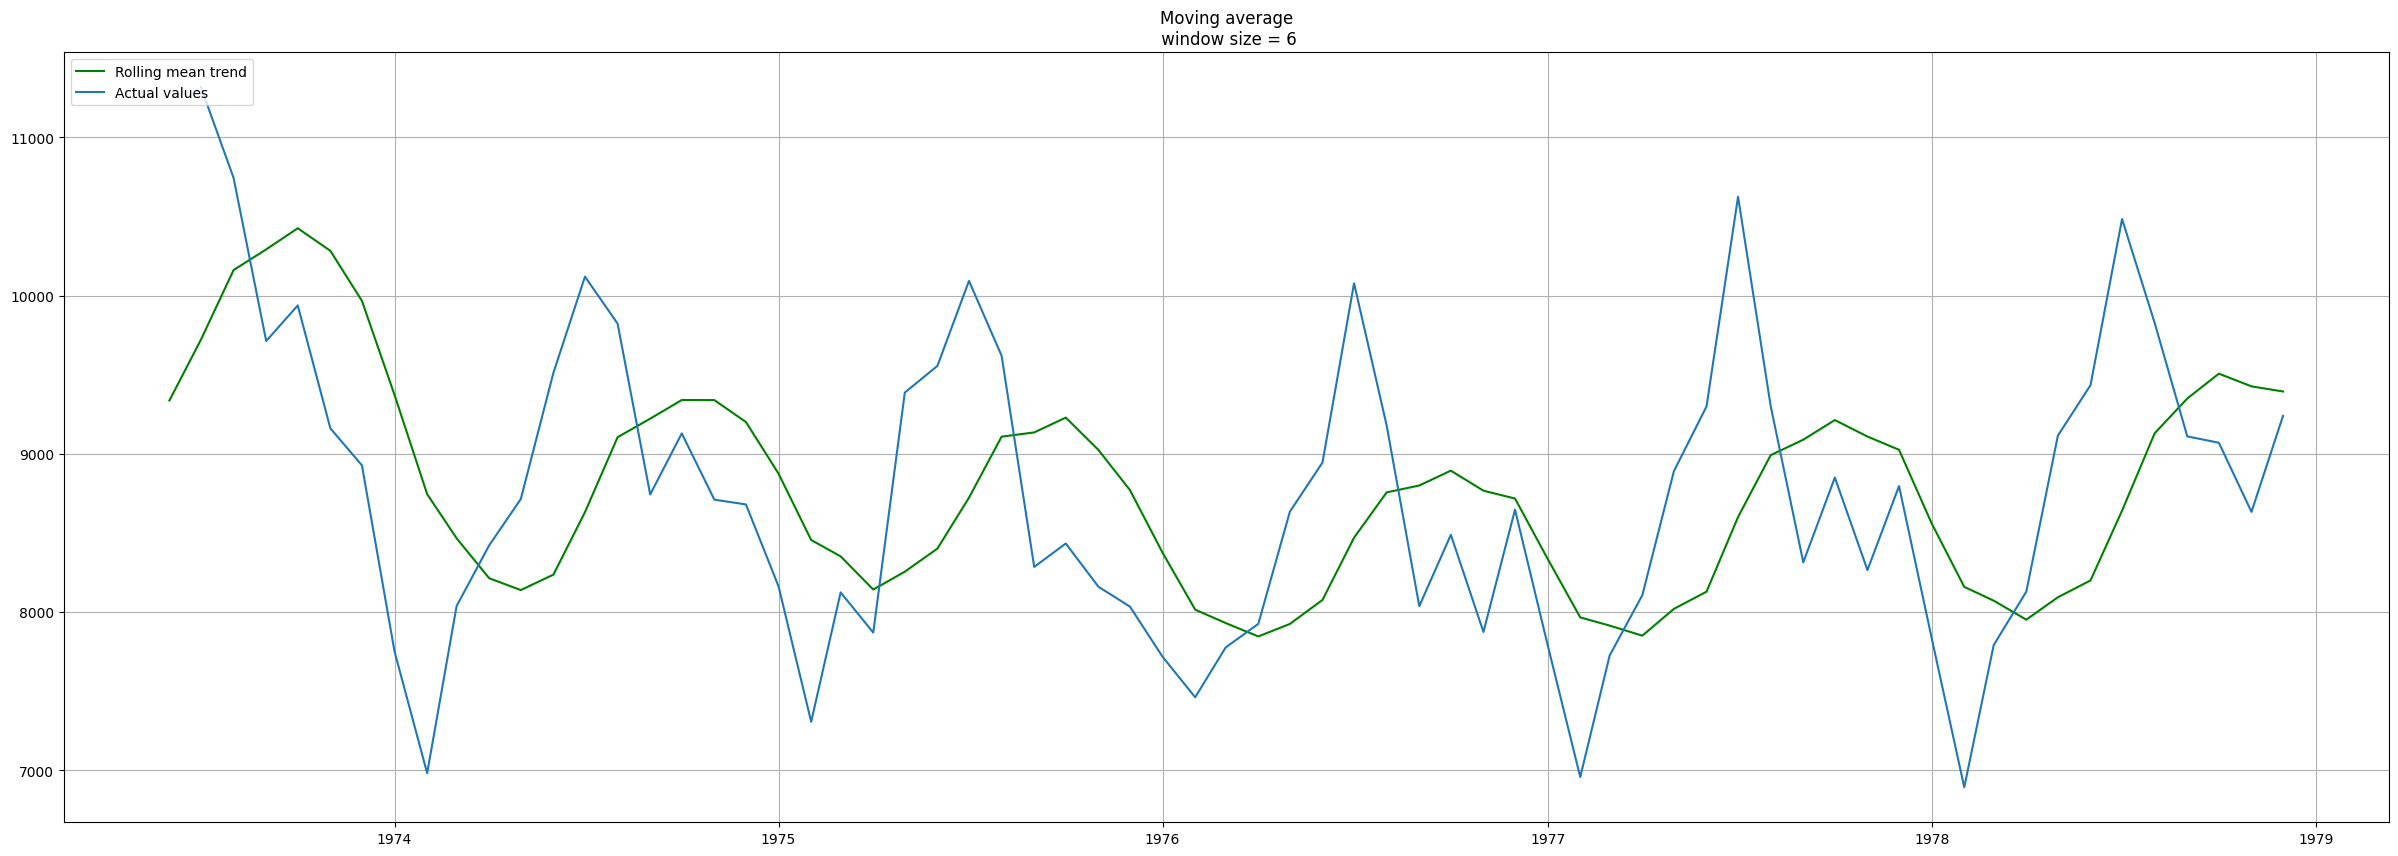

In [7]:
plotMovingAverage(dataset, 6)

При сглаживании по 6 месяцам лучше видно сезонность смертей

Проверим нашу модель на стационарность

In [8]:
data = dataset.copy()

In [9]:
def plotProcess(n_samples=72, rho=0):
    x = w = data.iloc[:, 0].values
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        print(sm.tsa.stattools.adfuller(x))
        


(-2.555798409635678, 0.10248122056865133, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 870.8496020346796)
(-4.544217283054496, 0.0001634622865164257, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 878.5315633906171)
(-0.936969908921666, 0.7755540916846106, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 899.0958166617409)
(3.317724379807092, 1.0, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 892.8204381655925)


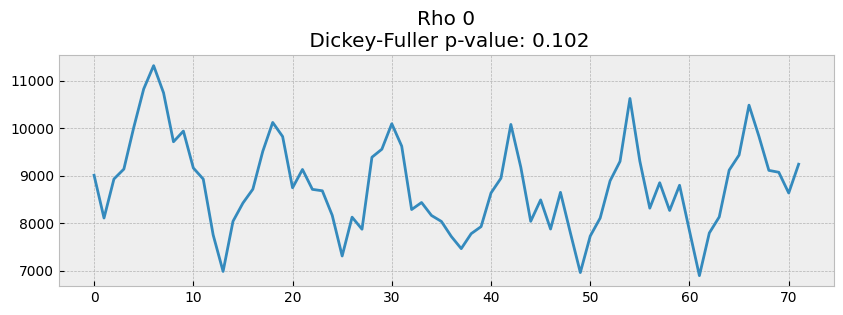

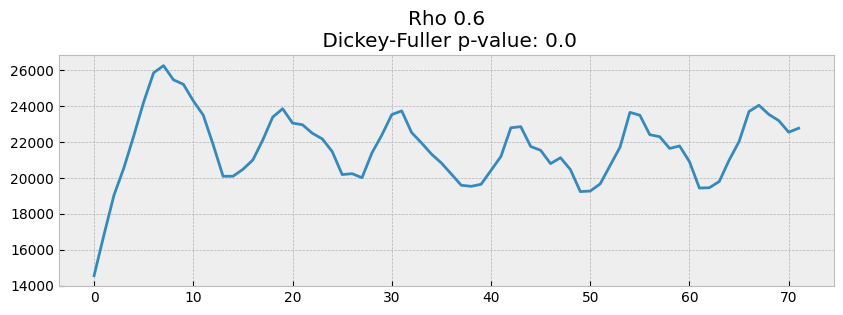

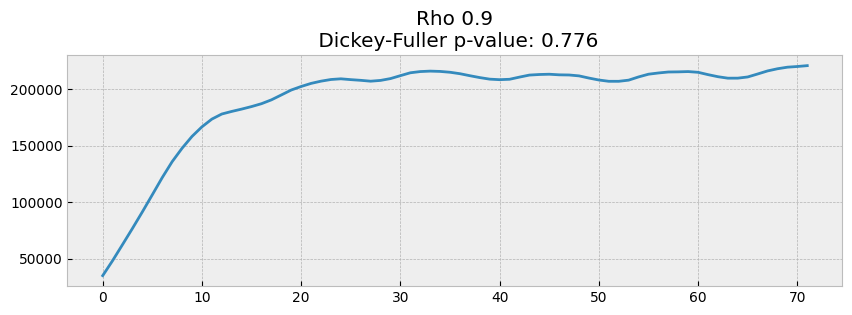

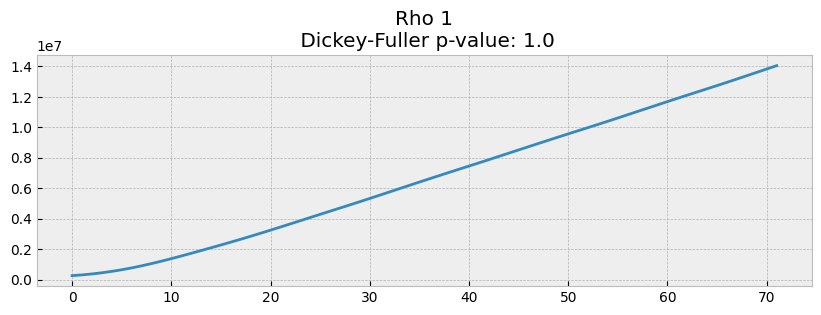

In [10]:
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(72,rho=rho)

На первых двух графиках (при p = 0 и p = 0.6) видим, что наш ряд - стационарный. При увеличении третьего значения p до 0,9 ряд перестает быть стационарным. При четвертом знаечнии - ряд также не стационарный. Мы видим это так как p-value приближается к единице или равно ей.

Разделим наши данные на train и test и подберем параметры с помощью auto_arima

In [11]:
train_data = dataset[:60]
test_data = dataset[60:]

In [12]:
model = pmdarima.arima.auto_arima(train_data, seasonal=True, m=12)

In [13]:
model.fit(train_data)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [14]:
predict = model.predict(n_periods=12)

In [15]:
predict

1978-01-01     8063.431152
1978-02-01     7375.526277
1978-03-01     8056.171917
1978-04-01     8290.203228
1978-05-01     9118.124962
1978-06-01     9516.200939
1978-07-01    10603.962975
1978-08-01     9602.179451
1978-09-01     8525.166586
1978-10-01     8963.782808
1978-11-01     8415.313117
1978-12-01     8842.215987
Freq: MS, dtype: float64

Посчитаем mse и rmse ошибки нашего предсказания

In [16]:
mse = mean_squared_error(test_data, predict)
rmse = np.sqrt(mse)
print(mse)
print(rmse)

84371.60691272223
290.4679102977164


Наглядно посмотрим разницу между предсказанием и настоящими данными

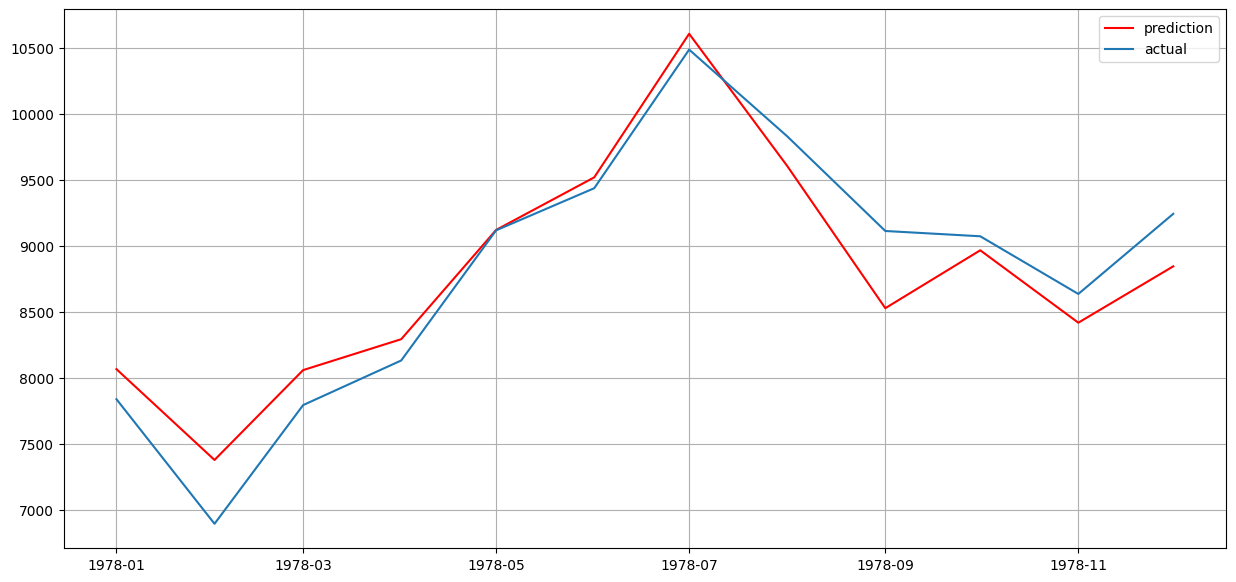

In [17]:
plt.figure(figsize=(15, 7))
plt.plot(predict, "r", label="prediction")
plt.plot(test_data, label="actual")
plt.legend(loc="best")
plt.grid(True);

Обучим модель на всех данных чтобы предсказать следующие два года

In [18]:
model_2y = sm.tsa.statespace.SARIMAX(dataset, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [19]:
forecast = model_2y.forecast(steps=24)

In [20]:
print(forecast)

1979-01-01     8371.005363
1979-02-01     7568.105525
1979-03-01     8350.466895
1979-04-01     8624.226580
1979-05-01     9525.254500
1979-06-01     9893.820510
1979-07-01    10941.161991
1979-08-01    10120.674247
1979-09-01     9201.778454
1979-10-01     9416.387444
1979-11-01     8920.867671
1979-12-01     9407.159115
1980-01-01     8585.090824
1980-02-01     7782.190987
1980-03-01     8564.552356
1980-04-01     8838.312041
1980-05-01     9739.339961
1980-06-01    10107.905971
1980-07-01    11155.247453
1980-08-01    10334.759709
1980-09-01     9415.863915
1980-10-01     9630.472905
1980-11-01     9134.953132
1980-12-01     9621.244577
Freq: MS, Name: predicted_mean, dtype: float64


Посмотрим как это будет выглядеть на графике

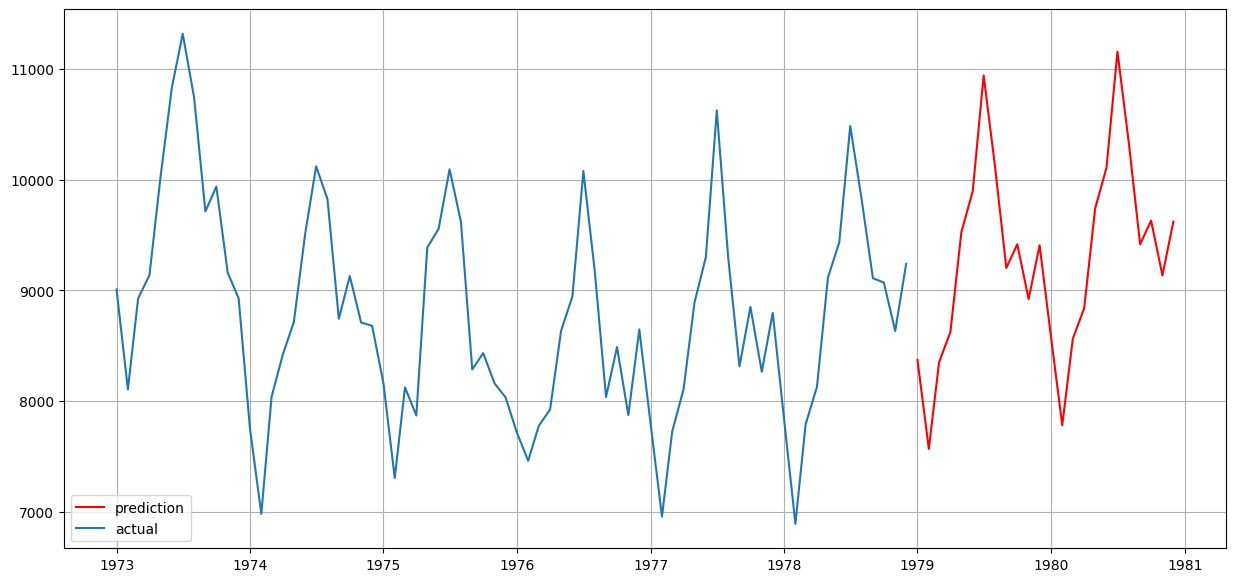

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(forecast, "r", label="prediction")
plt.plot(dataset, label="actual")
plt.legend(loc="best")
plt.grid(True);

Визуально, предстаказанный период имеет схожее "строение"

В качестве оценки ошибки использовалась RMSE (равная 290).

Для автоматичского подбора параметров использовалась auto_arima. А для педсказания модели - SARIMAX